# Αναγνώριση Προτύπων - 2η Εργαστηριακή Άσκηση
## Αναγνώριση φωνής με Κρυφά Μαρκοβιανά Μοντέλα και Αναδρομικά Νευρωνικά Δίκτυα 
### Καφίρης Αλέξανδρος - 03114044
### Ζαράνης Εμμανουήλ - 03114798

Στην εργαστηριακή άσκηση αυτή καλούμαστε να επεξεραστούμε και να ταξινομήσουμε ηχητικά αποσπάσματα. Τα αποσπάσματα αυτά περιέχουν εκφωνήσεις ψηφίων από διάφορους εκφωνητές.

<b>Βήμα 1</b><br> Στο βήμα αυτό θα χρησιμοποιήσουμε το εργαλείο Praat για να εξάγουμε κάποια χαρακτηριστικά 
από δύο εκφωνήσεις, τις onetwothree.wav, μία για εκφώνηση από άντρα και μία από γυναίκα. Παρακάτω φαίννται αρχικά τα ηχητικά αποσπάσματα από τις εκφωνήσεις μέσα στο περιβάλλον του Praat.

In [1]:
# Importing some useful libraries for further use
import librosa # For speech analysis
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
import numpy as np # For using arrays
import re # For the first part, in order to organize data
import os # For finding paths

plt.rcParams.update({'font.size': 16})

Παρακάτω φαίνεται η εκφώνηση του άντρα και στη συνέχεια της γυναίκας
<img src="./praat/man.png" title="Man" height="10">
<img src="./praat/woman.png" title="Woman">

Εκ πρώτης όψεως, βλέπουμε ότι η γυναικεία φωνή έχει μεγαλύτερη ένταση και πιό ευρύ φάσμα σε σχέση με τη φωνή του άντρα, πράγμα λογικό αφού η φωνή της γυναίκας εκτείνεται σε περισσότερες συχνότητες.
Παρακάτω κατασκευάζουμε κάποια διαγράμματα για τις τιμές του pitch και των formant που πήραμε μέσω του Praat.

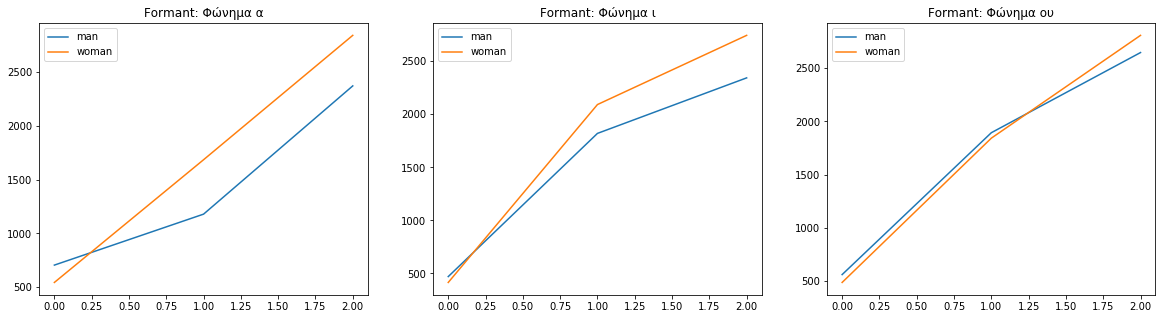

In [2]:
man_formant_a = [705.52, 1178.88, 2370.15]
man_formant_i = [470.94, 1819.59, 2342.64]
man_formant_ou = [561.19, 1894.03, 2647.07]

woman_formant_a = [544.44, 1684.25, 2839.53]
woman_formant_i = [415.7, 2091.3, 2743.05]
woman_formant_ou = [487.35, 1842.81, 2808.59]

fig = plt.subplots(1,3, figsize = (20,5))
plt.subplot(1,3,1)
plt.title('Formant: Φώνημα α')
plt.plot(man_formant_a)
plt.plot(woman_formant_a)
plt.legend(['man', 'woman'])
plt.subplot(1,3,2)
plt.title('Formant: Φώνημα ι')
plt.plot(man_formant_i)
plt.plot(woman_formant_i)
plt.legend(['man', 'woman'])
plt.subplot(1,3,3)
plt.title('Formant: Φώνημα ου')
plt.plot(man_formant_ou)
plt.plot(woman_formant_ou)
plt.legend(['man', 'woman'])

Βλέπουμε ότι τα formants της αντρικής φωνής βρίσκονται εν γένει σε χαμηλότερες συχνότητες σε σχέση με τα γυναικεία. Θα σχεδιάσουμε παρακάτω και τις μέσεις τιμές του pitch για τα παραπάνω φωνήματα

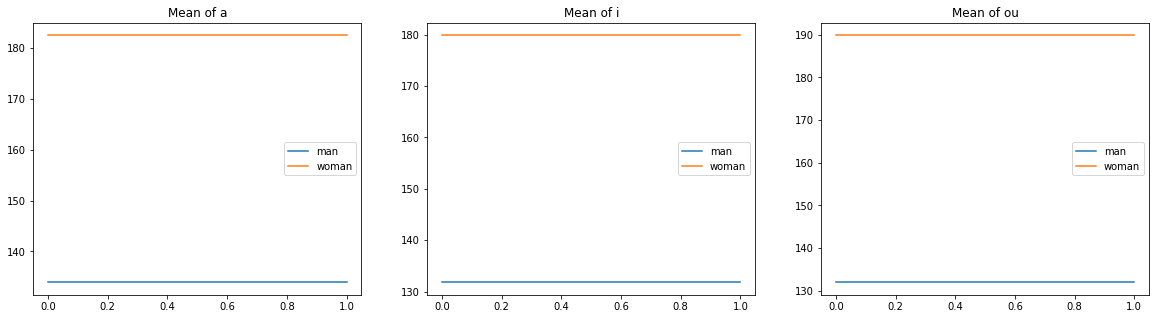

In [3]:
man_pitch_a = 133.88
man_pitch_i = 131.77
man_pitch_ou = 131.91

woman_pitch_a = 182.54
woman_pitch_i = 179.89
woman_pitch_ou = 189.88

fig = plt.subplots(1, 3, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title('Mean of a')
plt.plot([man_pitch_a, man_pitch_a])
plt.plot([woman_pitch_a, woman_pitch_a])
plt.legend(['man', 'woman'])
plt.subplot(1, 3, 2)
plt.title('Mean of i')
plt.plot([man_pitch_i, man_pitch_i])
plt.plot([woman_pitch_i, woman_pitch_i])
plt.legend(['man', 'woman'])
plt.subplot(1, 3, 3)
plt.title('Mean of ou')
plt.plot([man_pitch_ou, man_pitch_ou])
plt.plot([woman_pitch_ou, woman_pitch_ou])
plt.legend(['man', 'woman'])

Είναι ξεκάθαρο ότι οι γυναικείες φωνές έχουν και υψηλότερο pitch από τις αντρικές. Συνολικά, αυτό που μπορούμε να συμπεράνουμε είναι ότι τα αντρικά χαρακτηριστικά της φωνής είναι πιθανό να διαφέρουν αρκετά από τα γυναικεία και έτσι να τα χρησιμοποιήσουμε σαν χρήσιμα features για τον ορισμό διανυσμάτων περιγραφής των εκφωνήσεων.

<b>Βήμα 2:</b><br>Στο βήμα αυτό κατασκευάζουμε μια συνάρτηση που θα παίρνει σαν παράμετρο ένα path προς τον φάκελο που βρίσκονται τα ηχητικά αποσπάσματα, καθώς και τη συχνότητα δειγματοληψίας. Το διάβασμα των αρχείων ήχου γίνεται με χρήση της librosa και η συνάρτηση επιστρέφει τρεις λίστες, μία με τον αριθμό του ομιλητή, μία με το ψηφίο το οποίο εκφώνησε και μία ακόμη με το ηχητικό απόσπασμα αυτού του ψηφίου.<br><br>
Κατασκευάσαμε επίσης μία συνάρτηση rep_to_int, η οποία δέχεται σαν όρισμα μια συμβολοσειρά που αναπαριστά ένα ψηφίο και επιστρέφει τον αντίστοιχο ακέραιο. Αυτή η συνάρτηση χρησιμοποιείται για την κατασκευή της λίστας digit διότι υποθέτουμε ότι στη συνέχεια θα είναι πιο πρακτικό να έχουμε το ψηφίο στην αριθμητική του έκφραση παρά στη γραπτή.<br>

In [4]:
# Data parser for the digits
def data_parser(folderpath = 'None',
                frequency = 16e3):
    '''
    Input parameters:
        folderpath: Absolute path to folder where the files are. Assume that
                    the folder is located at the same directory as the script
        frequency: The sampling frequency
    '''
    
    # Check if parameters were given and if the path is valid
    assert folderpath is not None, 'data_parser: No folderpath was given.'
    
    # Compose absolute path to folder
    full_path = os.path.join(os.getcwd(), folderpath)
    assert full_path, 'data_parser: path \'{}\' does not exist.'.format(folderpath)
    
    # Create lists for the return data
    speaker = []
    digit = []
    sound = []
    
    # Find all sound files and read them
    all_files = os.walk(full_path)
    for _, _, paths in all_files:
        for path in paths:
            filepath = os.path.join(full_path, path)
            soundfile,y = librosa.core.load(filepath, sr = frequency)
            
            # Find speaker and digit
            filename = re.split('\.', path)[0]
            digit_said = re.split('\d', filename)[0]
            speaker_no = int(re.split('\D', filename).pop())
            
            # Append info to lists
            speaker.append(speaker_no)
            digit.append(rep_to_int(digit_said))
            sound.append(soundfile)
            
    return speaker, digit, sound

# A function to turn a string with a number representation to the respective integer
def rep_to_int(number = None):
    
    '''
        Input parameters:
            number: The string representation of the number to be converted to int
    '''
    
    assert number is not None, 'rep_to_int: no number was given as input'

    numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    
    for i, digit in enumerate(numbers):
        if number == digit:
            return i
    
    assert not True, 'rep_to_int: \'{}\' is not valid a valid number representation.'.format(number)
        
if __name__ == '__main__':
    
    speaker, digit, sound = data_parser('pr_lab2_2018-19_data/digits')


<b>Βήμα 3:</b><br>
Στο βήμα αυτό θα υπολογίσουμε τα MFCCs για κάθε ηχητικό απόσπασμα και πιο συγκεκριμένα τα 13 πρώτα για το καθένα. Τα MFCCs είναι είναι οι κύριες συνιστώσες που προκύπτουν από την εξής διαδικασία:
> - Υπολογίζουμε το φάσμα του ηχητικού σήματος.
> - Πενάμε την ενέργεια του φάσματος από μια συστοιχία Mel φίλτρων.
> - Για κάθε κεντρική συχνότητα παίρνουμε το λογάριθμό της.
> - Εφαρμόζουμε το μετασχηματισμό συνημιτόνου στα παραπάνω σήματα.
> - Εν τέλει, για κάθε συχνότητα έχουμε την αντίστοιχη συνιστώσα Mel.

Οι συνιστώσες Mel είναι μια καλή προσέγγιση του τρόπου με την οποία ο άνθρωπος αντιλαμβάνεται τον ήχο. Η κλίμακα Mel αναπαριστά με μεγάλη ακρίβεια την κατανομή των εντάσεων των συχνοτήτων που ακούει ο άνθρωπος και για αυτό προτιμάται σε ζητήματα που έχουν να κάνουν με τη φωνή.<br>
Παρακάτω φαίνετα ο κώδικας που εκτελεί τη διαδικασία εύρεσης των συνιστωσών Mel αλλά και των πρώτων και δεύτερων παραγώγων τους:

In [9]:
import warnings
warnings.filterwarnings("ignore")
# Creating a function to calculate the MFCCs of a given signal
def calc_mfccs(sound = None,
               sr = 16e3, 
               window = None,
               hop = None,
               mfccs_no = 13):
    
    '''
        Input parameters:
            sound: nd.array of sound file
            sr: Sampling rate of audio file. Deafult is 16kHz
            overlap: Window overlap for the FFT in MFCCs calculations (in ms)
            hop: Hop length of window (in ms)
    '''
    
    assert sound is not None, 'calc_mfccs: no sound was given.'
    
    # If no overlap and hop were given, then S is None, else
    # calculate the spectrogram S in order to determine chara-
    # cteristics of the MFCCs.
    if window is None or hop is None:
        spec = None
        
        # Calculate the MFCCs using librosa
        mfccs = librosa.feature.mfcc(sound, sr, spec, n_mfcc = mfccs_no)
        
    else:
        window = int(sr * window * 1e-3)
        hop = int(sr * hop * 1e-3)
        
        # Calculate the MFCCs using librosa
        mfccs = librosa.feature.mfcc(sound, sr, n_mfcc = mfccs_no, hop_length = hop, n_fft = window)
        
    return mfccs


if __name__ == '__main__':
    
    # Parameters for the MFCCs calculations
    hop = 10
    window = 25
    
    # Create a list for the MFCCs, the deltas and the delta-deltas
    mfccs = []
    deltas = []
    deltas2 = []
    
    for track in sound:
        
        # Calculate the 13 first MFCCs, the delta and the delta-delta
        x = calc_mfccs(track, window = window, hop = hop)
        
        delta = librosa.feature.delta(x)
        delta2 = librosa.feature.delta(x, order = 2)
        
        # Append the results to the appropriate lists
        mfccs.append(x)
        deltas.append(delta)
        deltas2.append(delta2)   
        


<b>Βήμα 4:</b><br>
Αναπαράσταση του 1ου και 2ου MFCC για τα δείγματα των ψηφίων 4 και 8. Επιλέχθηκαν οι αριθμοί αυτοί λόγω των αριθμών μητρώου: 0311404<b>4</b> και 0311479<b>8</b>. Η αναπαράσταση θα γίνει με ιστόγραμμα μέσω της βιβλιοθήκης seaborn:

In [10]:
# Collect 1st and 2nd MFCCs for digits 4 and 8
m4_1= np.asarray([])
m4_2 = np.asarray([])
m8_1 = np.asarray([])
m8_2 = np.asarray([])
for i, d in enumerate(digit):
    
    if d == 4:
        m4_1 = np.append(m4_1, mfccs[i][0])
        m4_2 = np.append(m4_2, mfccs[i][1])
    
    if d == 8:
        m8_1 = np.append(m8_1, mfccs[i][0])
        m8_2 = np.append(m8_2, mfccs[i][1])




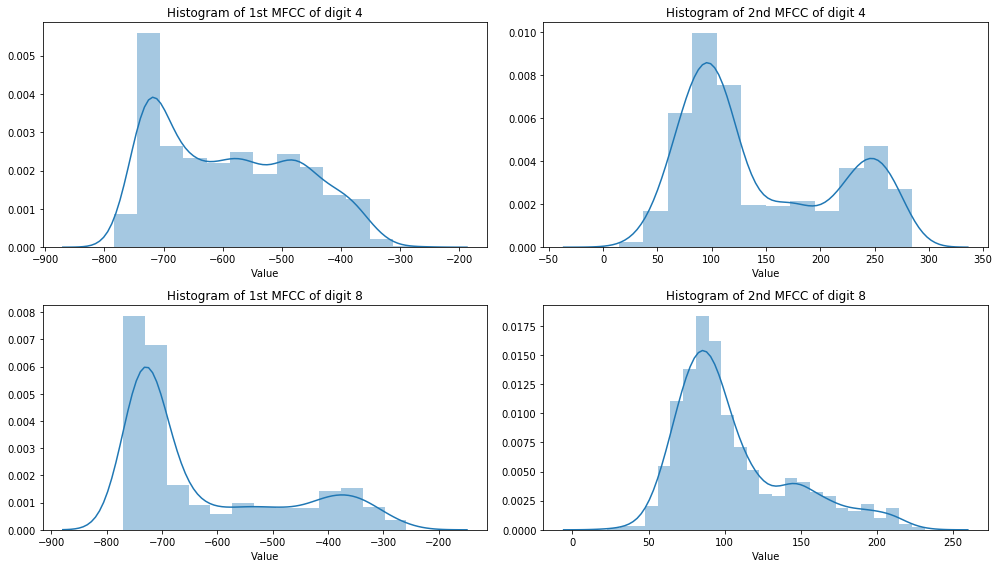

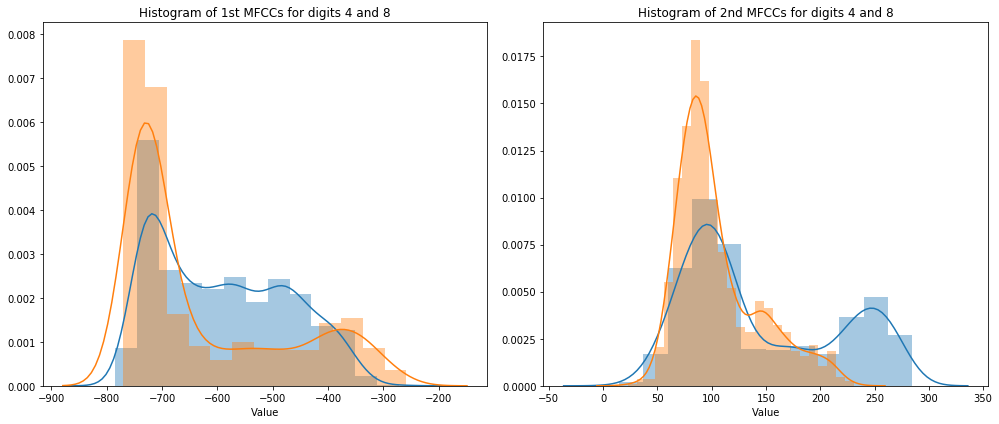

In [11]:
# Plot histograms in 4 different subplots       
fig = plt.subplots(2,2, figsize = (14,8))
plt.subplot(2,2,1)
plt.title('Histogram of 1st MFCC of digit 4')
plt.xlabel('Value')
sns.distplot(m4_1)
plt.subplot(2,2,2)
plt.title('Histogram of 2nd MFCC of digit 4')
plt.xlabel('Value')
sns.distplot(m4_2)
plt.subplot(2,2,3)
plt.title('Histogram of 1st MFCC of digit 8')
plt.xlabel('Value')
sns.distplot(m8_1)
plt.subplot(2,2,4)
plt.title('Histogram of 2nd MFCC of digit 8')
plt.xlabel('Value')
sns.distplot(m8_2)
plt.tight_layout()

# Plot histograms of 1st and 2nd formant on same figures
fig = plt.subplots(1,2, figsize = (14,6))
plt.subplot(1,2,1)
plt.title('Histogram of 1st MFCCs for digits 4 and 8')
plt.xlabel('Value')
sns.distplot(m4_1)
sns.distplot(m8_1)
plt.subplot(1,2,2)
plt.title('Histogram of 2nd MFCCs for digits 4 and 8')
plt.xlabel('Value')
sns.distplot(m4_2)
sns.distplot(m8_2)
plt.tight_layout()

<b>Σχόλια - Παρατηρήσεις:</b>
> Κάναμε διαφορετικού είδους διαγράμματα για να μπορέσουμε να έχουμε μια πιο ξεκάθαρη εικόνα για τις τιμές των δεδομένων μας. Αυτό που κυρίως παρατηρούμε είναι ότι τα πρώτα MFCCs για το ίδιο ψηφίο. Αυτό που παρατηρούμε είναι ότι για κάθε ψηφίο οι δύο πρώτες συνιστώσες Mel ακολουθούν μια παρόμοια κατανομή, ενώ για διαφορετικά ψηφία βλέπουμε ότι αυτές διαφέρουν αρκετά.

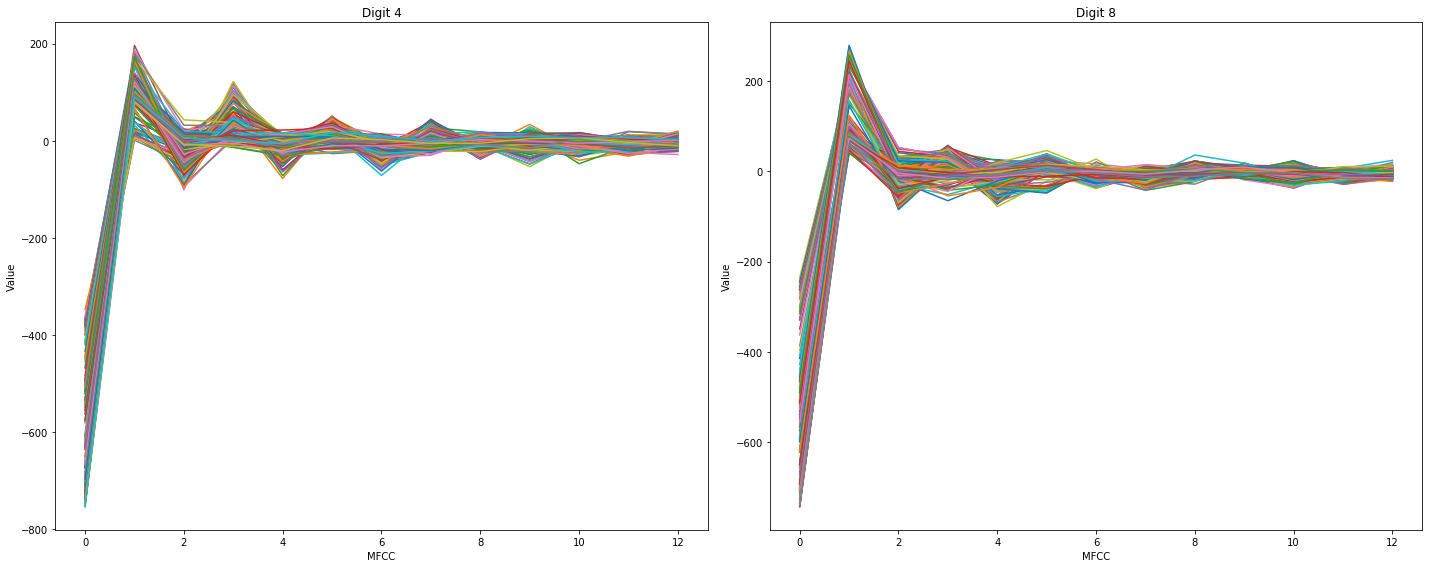

In [12]:
# Choose the track for the same digit (4 and 8) but with 2 different speakers
# We did it manually because it was pretty easy to do so
idx4_1 = 1
idx4_2 = 8
idx8_1 = 35
idx8_2 = 32

sp4_1 = mfccs[idx4_1]
sp4_2 = mfccs[idx4_2]
sp8_1 = mfccs[idx8_1]
sp8_2 = mfccs[idx8_2]

# Make 2 double plots, one for each digit
fig = plt.subplots(1,2, figsize=(20, 8))
plt.subplot(1,2,1)
plt.title('Digit 4')
plt.xlabel('MFCC')
plt.ylabel('Value')
plt.plot(sp4_1)
plt.plot(sp4_2)
plt.subplot(1,2,2)
plt.title('Digit 8')
plt.xlabel('MFCC')
plt.ylabel('Value')
plt.plot(sp8_1)
plt.plot(sp8_2)
plt.tight_layout()

Παρατηρούμε ότι παρόλο που έχουμε διαφορετικούς ομιλητές, οι συνιστώσες Mel τείνουν να παίρνουν πολύ παρόμοιες τιμές και να μην έχουν μεγάλη διακύμανση. Η χρησιμότητα αυτού είναι ότι μπορούμε να βγάζουμε συμπεράσματα για τα λεγόμενα ενός ομιλητή χωρίς να υπάρχει ουσιαστική εξάρτηση από τον τρόπο ομιλίας, τη χροιά ή άλλες σχετικές παραμέτρους. Αυτή είναι μια γνωστή ιδιότητα των MFCCs, όπως εξηγήσαμε προηγουμένως. Μπορούμε ακόμη να συνδυάσουμε αυτές τις τέσσερις γραφικές παραστάσεις για να επιβεβαιώσουμε ότι υπάρχει επαρκής διακρισιμότητα ανά κατηγορία.

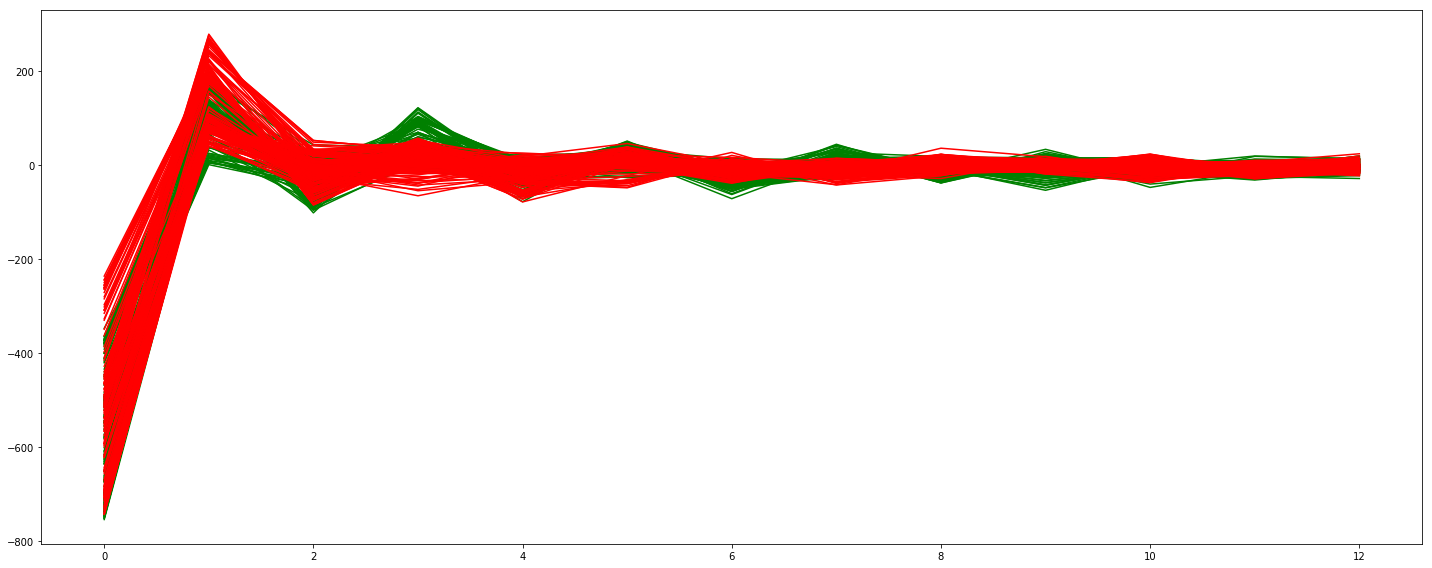

In [13]:
# Merge all 4 plots into one
fig = plt.figure(figsize = (20,8))
plt.plot(sp4_1, 'g')
plt.plot(sp4_2, 'g')
plt.plot(sp8_1, 'r')
plt.plot(sp8_2, 'r')
plt.tight_layout()

Στη συνέχεια θα κατασκευάσουμε το spectrogram των παραπάνω ηχητικών αποσπασμάτων μέσω της βιβλιοθήκης της librosa.

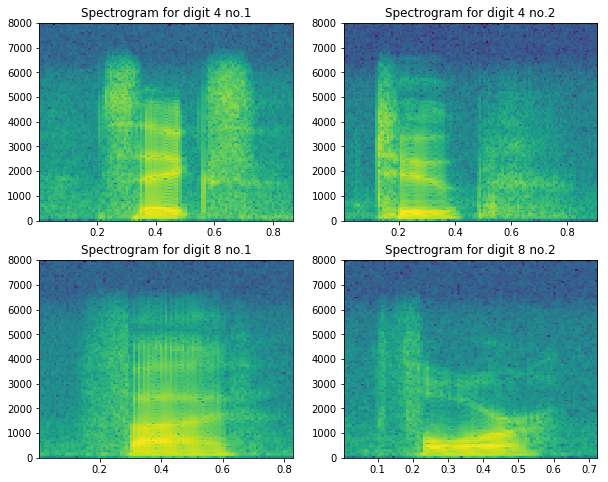

<Figure size 432x288 with 0 Axes>

In [14]:
# Import librosa.display to show the spectrogramm
import librosa.display

# Calculate the parameters of the STFT
window = int(16e3 * 25 * 1e-3)
hop = int(16e3 * 10 * 1e-3)

# Create the plot
fig = plt.subplots(2, 2, figsize = (10, 8))
plt.subplot(2,2,1)
plt.title('Spectrogram for digit 4 no.1')
Pxx, freqs, bins, im = plt.specgram(sound[idx4_1], Fs=16e3)
plt.subplot(2, 2, 2)
plt.title('Spectrogram for digit 4 no.2')
Pxx, freqs, bins, im = plt.specgram(sound[idx4_2], Fs=16e3)
plt.subplot(2, 2, 3)
plt.title('Spectrogram for digit 8 no.1')
Pxx, freqs, bins, im = plt.specgram(sound[idx8_1], Fs=16e3)
plt.subplot(2, 2, 4)
plt.title('Spectrogram for digit 8 no.2')
Pxx, freqs, bins, im = plt.specgram(sound[idx8_2], Fs=16e3)
plt.show()
plt.tight_layout()

Όπως φαίνεται και απο τα σπεκτρογράμματα, βλέπουμε μεγάλες αποκλίσεις στο πώς αυτά διαμορφώνονται ακόμα και όταν οι διαφορετικοί ομιλητές λένε το ίδιο ψηφίο. Ακόμα και για το ψηφίο 4, που τα σπεκτρογράμματα έχουν παρόμοια μορφή Συμπεραίνουμε ότι η επιλογή του STFT δεν θα είναι μάλλον τόσο αποτελεσματική όσο των MFCCs για την ταξινόμηση των ψηφίων μας.

<b>Βήμα 5:</b><br>
    Στο βήμα αυτό θα εξάγουμε ένα μοναδικό διάνυσμα χαρακτηριστικών για κάθε δείγμα και θα κάνουμε κάποια scatter plots μέσω του matplotlib για να δούμε πώς κατανέμονται αυτά τα χαρακτηριστικά στο χώρο.

In [77]:
# We group our data by making a single feature vector for
# each utterance. We calculate the mean and variance
# of each indivudual feature across the widnows of each
# utterance

# We make an array with the samples
features = []
# We repeat the following process for each utterance
for utt, d in enumerate(digit):
    
    # Locate the features for the appropriate sample
    m = mfccs[utt]
    d = deltas[utt]
    dd = deltas2[utt]
    
  
    # Calculate mean and variance for mfccs
    mfcc_mean = np.mean(m, axis = 1)
    mfcc_var = np.var(m, axis = 1)
    
    
    # Calculate the mean and variance of deltas
    delta_mean = np.mean(d, axis = 1)
    delta_var = np.var(d, axis = 1)
    
    # Calculate the mean and variance of delta-delta
    delta2_mean = np.mean(dd, axis = 1)
    delta2_var = np.var(dd, axis = 1)
    
    # Make the feature vector
    feature_vector = np.concatenate([mfcc_mean, mfcc_var,
                                     delta_mean, delta_var,
                                     delta2_mean, delta2_var])
    
    # Append the feature vector to the whole features vector
    features.append(feature_vector)
    
# Turn the list to a numpy array
features = np.asarray(features)
print(features.shape)

(133, 78)


Τώρα θα απεικονίσουμε τα δύο πρώτα χαρακτηριστικά για κάθε γενικότερη ομάδα χαρακτηριστικών, δηλαδή μέση τιμή και διακύμανση των MFCCs, deltas και delta-deltas.

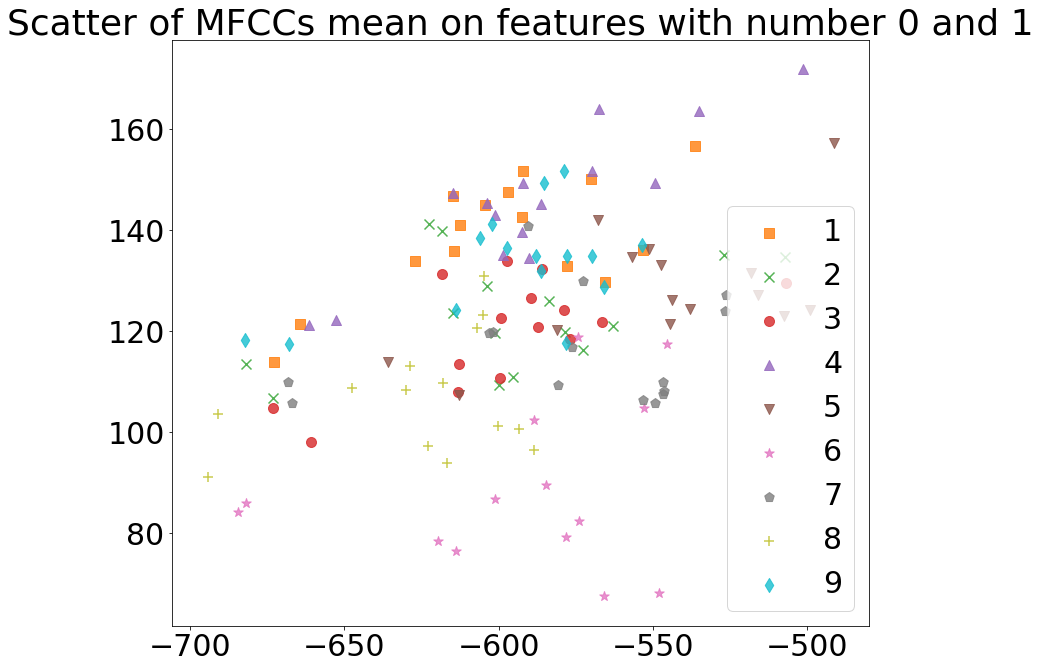

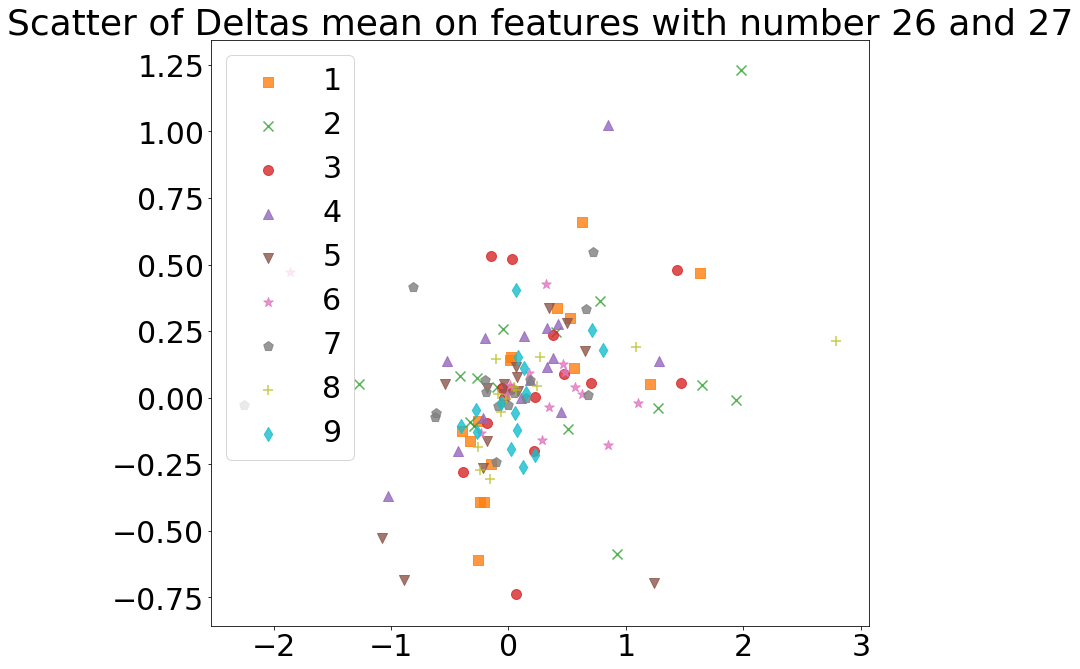

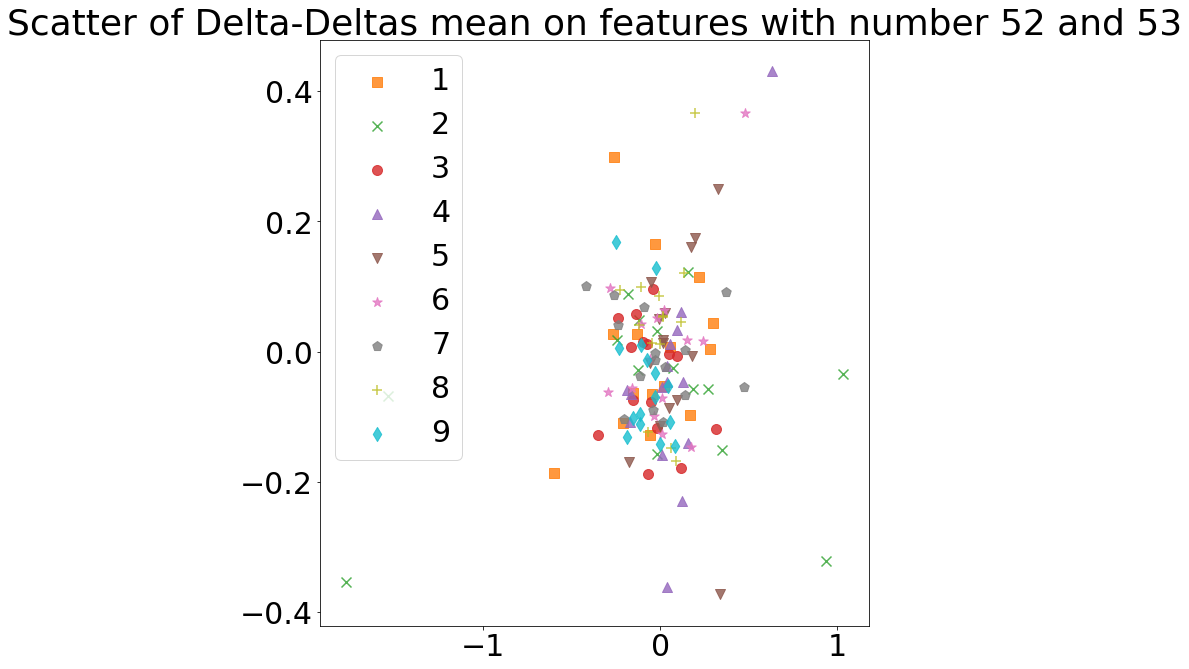

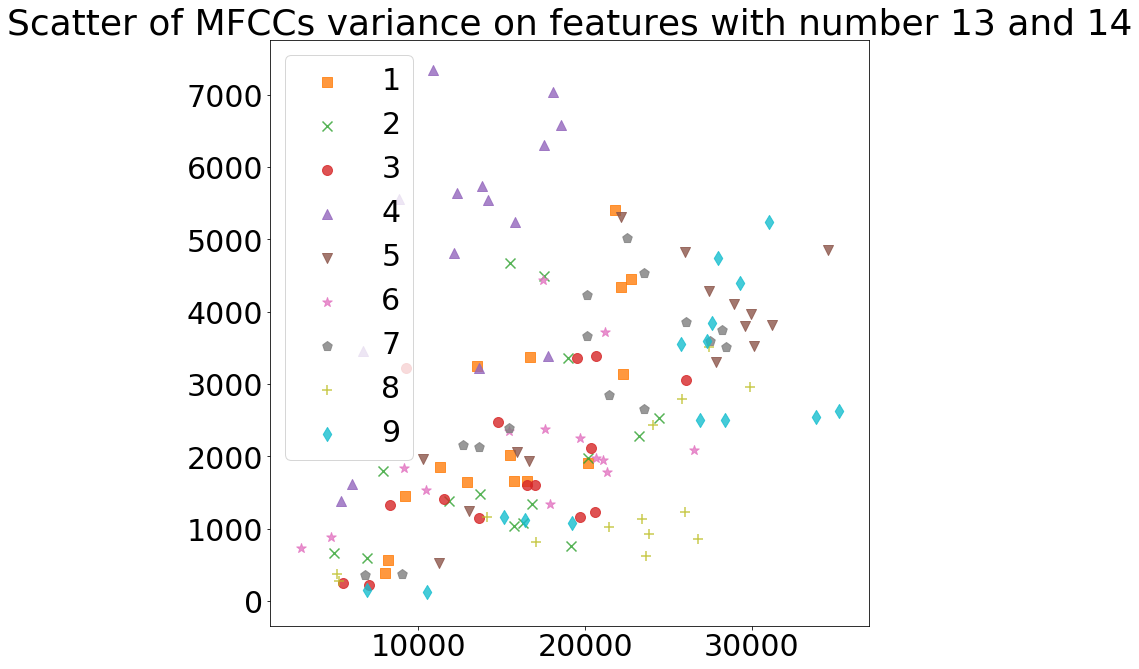

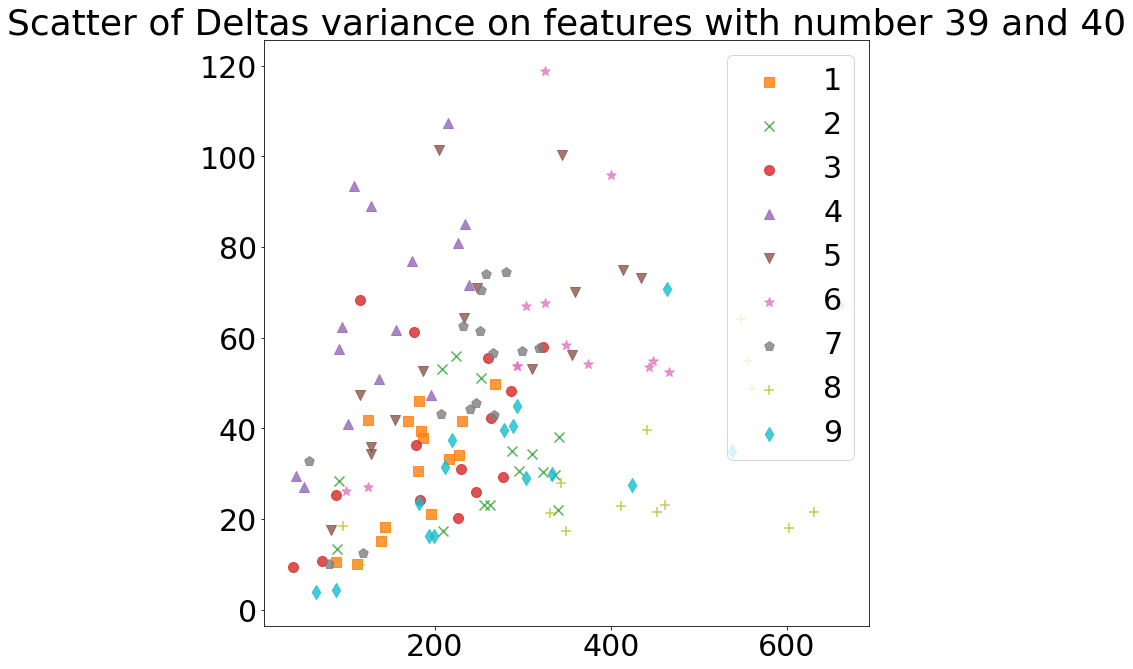

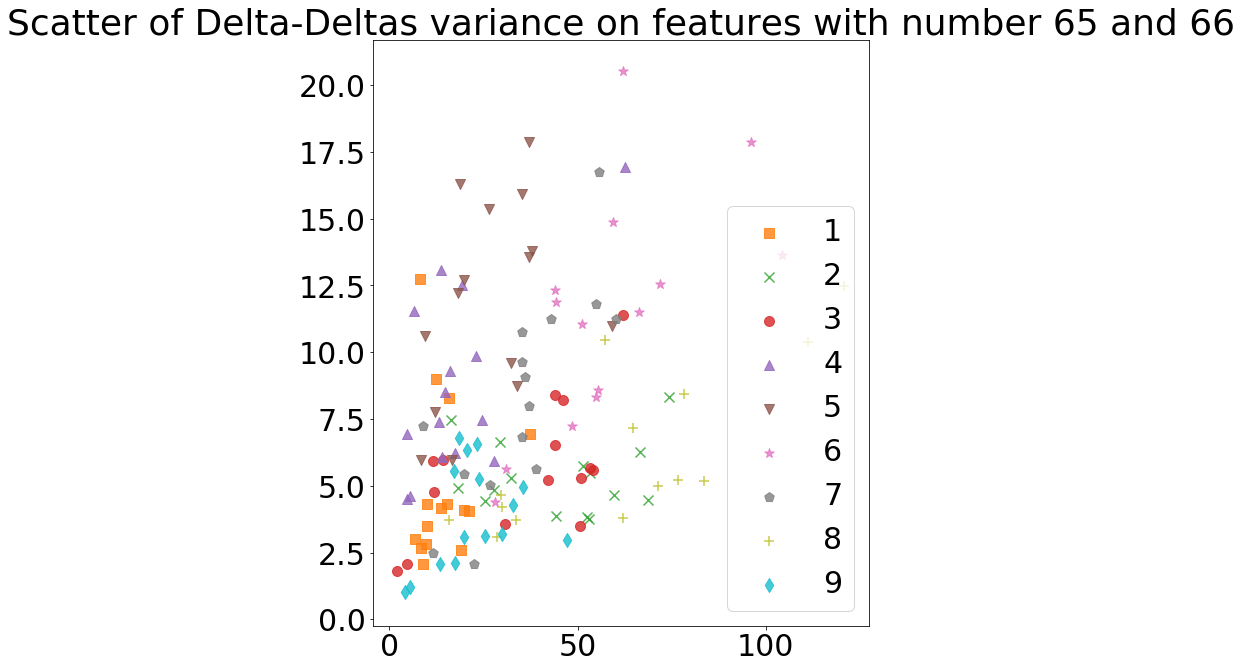

In [78]:
# Create a scatter for MFCCs and paint the points accordingly

# A function to plot a scatter of 2 features
def scatter_of_digits(data, 
                     ftype,
                     feat_x,
                     feat_y):
    
    # The colors to use
    colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    #The markers to use
    markers = ('s', 'x', 'o', '^', 'v','*','p','+','d')
    
    # Make figure
    fig = plt.figure(figsize = (14,10))
    plt.rcParams.update({'font.size': 30})
    plt.title('Scatter of {} on features with number {} and {}'.format(ftype, feat_x, feat_y))
    
    # Find the coordinates of each digit
    for i in range(1,10):
        
        # The coordinates
        x = []
        y = []
        
        for j, d in enumerate(digit):
            if d == i:
                x.append(data[j, feat_x])
                y.append(data[j, feat_y])
                #plt.scatter(x=features[j,feat_x], y=features[j, feat_y], color = colors[i - 1],marker=markers[i-1], s=200,label=i)
        
        # Put those points on scatter
        plt.scatter(x, y, color = colors[i - 1],marker=markers[i-1],alpha=0.8, s=100)
    
    plt.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.tight_layout()

if __name__ == '__main__':
    scatter_of_digits(features, 'MFCCs mean', 0, 1)
    scatter_of_digits(features, 'Deltas mean', 26,27)
    scatter_of_digits(features, 'Delta-Deltas mean', 52, 53)
    scatter_of_digits(features, 'MFCCs variance', 13,14)
    scatter_of_digits(features, 'Deltas variance', 39, 40)
    scatter_of_digits(features, 'Delta-Deltas variance', 65,66)

Βημα 6:
Σε αυτό το βήμα εφαρμόζουμε PCA μειώνοντας την διάσταση του feature vector σε 2. Ουσιαστικά δεν θα κρατήσουμε τα 2 πιο σημαντικά features αλλά θα φτιάξουμε 2 principal components τα οποία θα αποτελέσουν γραμμικό συνδυασμό των προηγούμενων 78 features.

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X_train = features

scaler = StandardScaler()
X_trans = scaler.fit_transform(X_train) 

pca = PCA(n_components=2)

pca_fitted = pca.fit(X_trans)
reduced_train_2 = pca_fitted.transform(X_trans)

print(pca.explained_variance_ratio_)


[0.10348612 0.08632637]


Παραπάνω φαίνεται ότι η πρώτη συνιστώσα διατηρεί το 10% του variance ενώ η δεύτερη μόνο το 8.6%.
Τα παραπάνω ποσοστά δείχνουν πόσο σημαντικό είναι κάθε principal component, αφού όσο μεγαλύτερο variance ratio έχει, "τόσο περισσότερη πληροφορία κρατάει".


Παρακάτω φαίνεται το νέο scatter plot ύστερα από την εφαρμογή του PCA έχοντας κρατήσει 2 features.


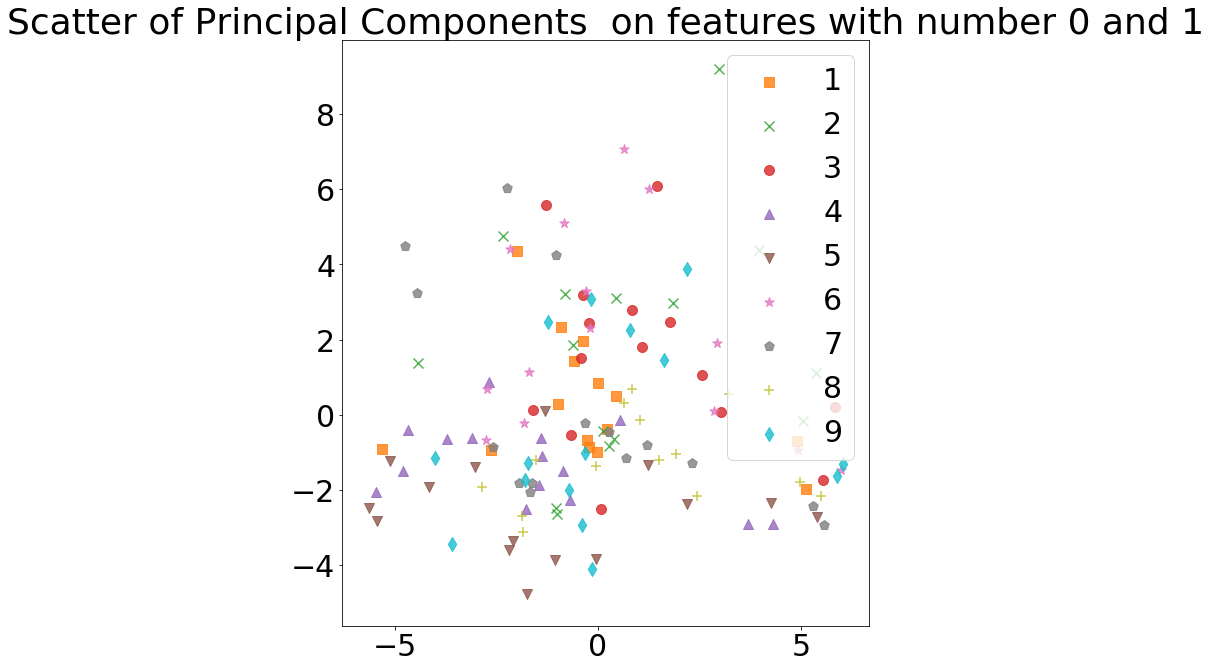

In [83]:
scatter_of_digits(reduced_train_2, 'Principal Components ', 0, 1)

Παρακάτω επαναλαμβάνουμε την διαδικασία κρατώντας τώρα 3 principal components.

In [84]:
pca = PCA(n_components=3)

pca_fitted = pca.fit(X_trans)
reduced_train_3 = pca_fitted.transform(X_trans)

print(pca.explained_variance_ratio_)

[0.10348612 0.08632637 0.06689318]


Παρατηρούμε τώρα ότι το 3ο principal component μπεριέχει και αυτό 6,6% του variance. Συνεπώς, οι μείωση των διαστάσεων στις 2 ίσως να μην ήταν τόσο πετυχημένη. Στις 3 είναι λίγο περισσότερο αλλά και πάλι δεν έχουμε κρατήσει αρκετή πληροφορία του dataset.

Παρακάτω φαίνεται η κατανομή των principal components στις 3 διαστάσεις.

Text(0.5, 0, 'Principal Component 3')

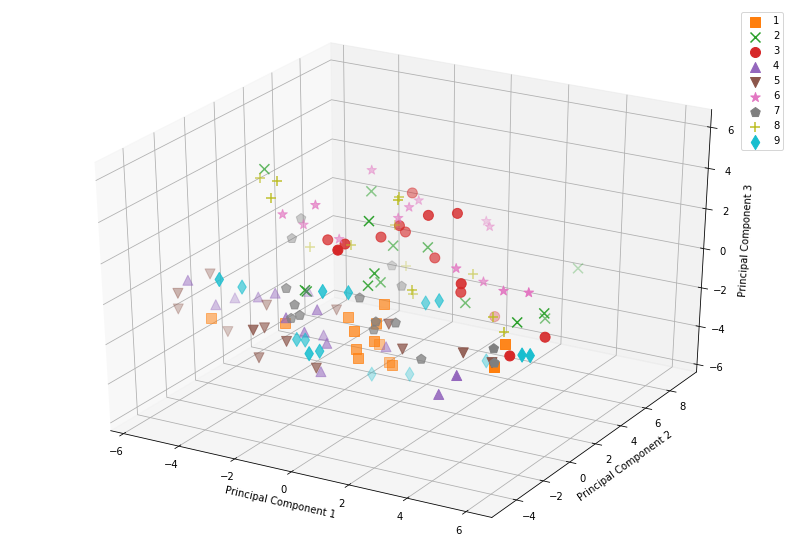

In [85]:
from mpl_toolkits.mplot3d import Axes3D

fig2 = plt.figure(figsize = (14,10))
plt.rcParams.update({'font.size': 10})
ax = fig2.add_subplot(111, projection='3d')

# The colors to use
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

#The markers to use
markers = ('s', 'x', 'o', '^', 'v','*','p','+','d')

# Find the coordinates of each digit
for i in range(1,10):

    # The coordinates
    x = []
    y = []
    z=[]
    for j, d in enumerate(digit):
        if d == i:
            x.append(reduced_train_3[j][0])
            y.append(reduced_train_3[j][1])
            z.append(reduced_train_3[j][2])

    # Put those points on scatter
    ax.scatter(x, y,z, zdir='z',color = colors[i - 1],marker=markers[i-1],s=100)

ax.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9'])
   
    
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

Βημα 7:

In [86]:
speaker = np.asarray(speaker)
digit = np.asarray(digit)

dataset_2_feat = list(zip(reduced_train_2,speaker,digit))


#make dataset in appropriate form
dataset_2 = []
for sample in dataset_2_feat:
    dataset_2.append([sample[0][0],sample[0][1],sample[1],sample[2]] )

dataset_2 = np.asarray(dataset_2)



dataset_3_feat = list(zip(reduced_train_3,speaker,digit))


#make dataset in appropriate form
dataset_3 = []
for sample in dataset_3_feat:
    dataset_3.append([sample[0][0],sample[0][1],sample[0][2],sample[1],sample[2]] )

dataset_3 = np.asarray(dataset_3)

In [87]:
speaker = np.asarray(speaker)
digit = np.asarray(digit)

dataset_all_feat =list(zip(features,speaker,digit))
#print(dataset_all_feat)
dataset=[]
for sample in dataset_all_feat:
    features_list=sample[0].tolist()
    
    
    features_list.append(sample[1])
    features_list.append(sample[2])

    dataset.append(features_list)
dataset = np.asarray(dataset)


Στην συνέχεια έχουμε υλοποιήσει κλάση η μπορεί να χρησιμοποιηθεί για τον χωρισμό ενός dataset σε train και test set,δεδομένων κάποιων ποσοστών για τον χωρισμό.

In [88]:
import math

class Data_splitter:
    
    def random_split(self,dataset, lengths):
        """
        Randomly split a dataset into non-overlapping new datasets of given lengths.

        Arguments:
            dataset (Dataset): Dataset to be split
            lengths (sequence): lengths of splits to be produced
        """
        if sum(lengths) != len(dataset):
            raise ValueError("Sum of input lengths does not equal the length of the input dataset!")
        
        a=[]
        prev=0
        for length in lengths:
            a.append(dataset[prev:prev+length])
            prev = length
        
        return a
    
    #if shuffle is true the dataset given will be shuffled too!
    def split_perc_(self,dataset,percentages,shuffle=None):
        
        
        dataset_len = len(dataset)
        
        if shuffle is True:
            np.random.shuffle(dataset)
        
        if sum(percentages) != 100:
            raise ValueError("Sum of percentages does not equal 100!")
        lengths=[]
        for counter,percentage in enumerate(percentages):
            if(counter<len(percentages)-1):
                lengths.append( math.floor(percentage/100*dataset_len) )
                
            else:
                mysum = sum(lengths)
                lengths.append(dataset_len-mysum)
        return self.random_split(dataset,lengths)
            

In [109]:
from sklearn.preprocessing import MinMaxScaler

data_splitter=Data_splitter()
[train,test] = data_splitter.split_perc_(dataset,[70,30],shuffle=True)
#[train,test] = data_splitter.split_perc_(dataset_3,[70,30],shuffle=False)

features_train = train[:,0:78]

#scaler1 = StandardScaler()
#features_train = scaler1.fit_transform(features_train) 

scaler2 = MinMaxScaler()
features_train = scaler2.fit_transform(features_train) 


speaker_train = train[:,78]
labels_train = train[:,79].astype(int)



features_test = test[:,0:78]
#features_test = scaler1.transform(features_test)
features_test = scaler2.transform(features_test) 

speaker_test = test[:,78]
labels_test = test[:,79].astype(int)


Χρηση του Bayesian ταξινομητη που ειχαμε φτιαξει!


In [110]:

# This function calculates mean and variance of each pixel for a digit and returns 2 np.ndarrays respectively.
def stats_for_label(label,
                    X_train,
                    y_train):
    
    indexes = np.where(y_train == label) # pick the indexes of the label
    mean_of_label = np.mean(X_train[indexes,:].squeeze(),axis=0) # calculate the mean of samples with that label
    var_of_label = np.var(X_train[indexes,:].squeeze(),axis=0) # calculate the variance of samples with that label
    return mean_of_label, var_of_label


# Given the labels part of the dataset, calculate the a priori probabilites.
def a_priori_calc(labels,
                  visualize = True):
    
    unique_labels = np.unique(labels) # locate the different labels
    bin_count = np.bincount(labels) # count each label appearences
    

    if visualize:
        plt.xlabel('Digit')
        plt.ylabel('Appearencies')
        plt.title('Labels appearencies')
        plt.stem(range(10),bin_count)

    return unique_labels,bin_count / labels.shape

from sklearn.base import BaseEstimator, ClassifierMixin
# Create the Gaussian Naive Bayes classifier class
class Gaussian_Naive_Bayes_classifier(BaseEstimator,ClassifierMixin):
    
    
    def __init__(self):
        self.X_mean = None
        self.X_var = None
        self.a_priory = None
        
        
    def fit(self,X_train,y_train,var=None):
        #Find all different labels (digits)
        self.labels_values = np.unique(y_train)
        
        dims = (aux_x,aux_y) = (self.labels_values.shape[0],X_train.shape[1])
        
        #computing mean and var for every feature (xi) according to its class (y)
        
        self.X_mean = np.empty(dims)
        self.X_var = np.empty(dims)
     
        for i,label in enumerate (self.labels_values):
            d_mean, d_var = stats_for_label(label,X_train,y_train)
            self.X_mean[label-1] = d_mean
            self.X_var[label-1] = d_var
            #self.X_var[label] = np.ones(dims[1])
        
        if var is not None:
            self.X_var[:]=var
        
        temp,self.a_priory = a_priori_calc(y_train,visualize=False)

    def computation_of_gaussian_prop(self,sample,mean,var):
        
        # Sos we give as argument the var and not the std!!
        temp1 = ((-1) * np.power((sample - mean),2) / ( 2 * var ))
        temp2 = np.exp( temp1 )
        temp3 = 1 / np.sqrt( 2* math.pi* var )
        
        return temp3*temp2   
    
    
    def makeprediction(self,sample,mean_of_every_label,var_of_every_label,labels):
        
        propabilities = np.empty(labels.shape[0])
        
        for i,label in enumerate (labels):
            #compute the product of P(xi|y) for i=1..n
            props = self.computation_of_gaussian_prop(sample,mean_of_every_label[label-1],var_of_every_label[label-1])
            product=1
            for x in props:
                if math.isnan(x)==False:
                    product = x*product
                
            propabilities[label-1] = product * self.a_priory[label]
            
        return np.argmax(propabilities)+1
    
    
    def predict(self,X_test):
        
        number_of_samples, number_of_features = X_test.shape
        
        #now for each sample lets make a prediction!
        pred = np.empty(number_of_samples)
        
        counter=0
        
        for sample in X_test:
            pred[counter] = self.makeprediction(sample,self.X_mean,self.X_var,self.labels_values)
            counter += 1
            
            
        return pred.astype(np.int64)
    
    
    def score(self,X_test,y_test):
        
        results = self.predict(X_test)# make a list for each prediction made
        flags = y_test - results # subtruct from label array to find the correct predictions (those with zero)
        correct = np.count_nonzero(flags == 0) # count the correct predictions
        return correct / y_test.shape[0]

Δοκιμάζουμε τον Gaussian Classifier που ειχαμε υλοποιήσει στο προηγούμενο εργαστηριο..

In [111]:
gnb1 = Gaussian_Naive_Bayes_classifier()

print('Accuracy of Bayes classifier:')

gnb1.fit(features_train,labels_train)

print('Score: {}%'.format(round(gnb1.score(features_test,labels_test)*100,2)))



Accuracy of Bayes classifier:
Score: 70.0%


Δοκιμάζοντας αυτόν του scikit έχουμε:

In [112]:
from sklearn.naive_bayes import GaussianNB
gnb_sci = GaussianNB()

print('Accuracy of scikit Bayes classifier (NO noise in dataset)')
print('===================================')
gnb_sci.fit(features_train,labels_train)
print('Accuracy: {}% \n'.format(round(gnb_sci.score(features_test,labels_test)*100,2)))

Accuracy of scikit Bayes classifier (NO noise in dataset)
Accuracy: 70.0% 



Παρατηρούμε ότι οι δύο ταξινομητές δίνουν ίδιο αποτέλεσμα, κάτι το οποίο είναι λογικό.

Βάζουμε και μερικούς ακόμα classifiers και παρατηρούμε ότι ο Knn έχει accuracy κοντά στον GaussianNB classifier ενώ τα SVM απέχουν αρκετά απο αυτούς.

In [113]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3,n_jobs = -1)
knn.fit(features_train,labels_train)
print(knn.score(features_test,labels_test))

from sklearn import svm

# edw tha valw merikous akoma...    
models = [svm.SVC(kernel='rbf'),svm.SVC(kernel='sigmoid')]
  
for model in models:
    mysvm = model
    mysvm.fit(features_train,labels_train)
    print(str(model)+":")
    print(mysvm.score(features_test,labels_test))
    print("=========================")

0.55
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False):
0.1
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False):
0.1


Στην συνέχεια θα προσθέσουμε στο feature vector μας εκτός απο τα mfccs και το zero crossing rate.
Με αυτήν την προσθήκη αναμένουμε να έχουμε μείωση του ποσοστού επιτυχίας καθώς προσθέτουμε πληροφορία η οποία δεν βοηθάει στην αναγνώριση.Αν η πληροφορία που προσθέταμε ήταν χρήσιμη θα είχαμε αύξηση του ποσοστού. Βέβαια,
αυτό δεν σημάινει πάντα ότι η προσθήκη οποιασδήποτε πληροφορίας στα features βοηθάει τους ταξινομητές... Θα μπορούσε η
προστιθέμενη πληροφορία να ήταν παραγώμενη από άλλη(π.χ. γραμμικώς εξαρτημένη) και να έκανε το μοντέλο πιο αργό ενώ δεν
θα έδινε καμία απολύτως βελτίωση.

In [140]:
# Parameters for the ZCR calculations
hop = 10
window = 25

zcrs=[]
delta_zcr=[]
delta_2_zcr=[]
for track in sound:
    # Calculate the 13 first MFCCs, the delta and the delta-delta
        x = librosa.feature.zero_crossing_rate(track, frame_length = window, hop_length = hop)
        
        delta = librosa.feature.delta(x)
        delta2 = librosa.feature.delta(x, order = 2)
        # Append the results to the appropriate lists
        zcrs.append(x)
        delta_zcr.append(delta)
        delta_2_zcr.append(delta2)
        
# We make an array with the samples
new_features = []
# We repeat the following process for each utterance
for utt, d in enumerate(digit):
    
    # Locate the features for the appropriate sample
    z = zcrs[utt]    
    d=delta_zcr[utt]
    dd=delta_2_zcr[utt]

    # Calculate mean and variance for mfccs
    zcr_mean = np.mean(z, axis = 1)
    
    zcr_var = np.var(z, axis = 1)
    
    zcr_delta_mean = np.mean(d, axis = 1)
    zcr_delta_var = np.var(d, axis = 1)
    
    zcr_delta2_mean = np.mean(dd, axis = 1)
    zcr_delta2_var = np.var(dd, axis = 1)
    # Make the feature vector
    feature_vector = np.concatenate([mfcc_mean, mfcc_var,
                                     delta_mean, delta_var,
                                     delta2_mean, delta2_var,
                                     zcr_mean,zcr_var,
                                     zcr_delta_mean,zcr_delta_var,
                                     zcr_delta2_mean,zcr_delta2_var])
    
    # Append the feature vector to the whole features vector
    new_features.append(feature_vector)
    
# Turn the list to a numpy array
new_features = np.asarray(new_features)

print(new_features.shape)


#pca = PCA(n_components=2)

#X_train=new_features
#pca_fitted = pca.fit(X_train)
#reduced_train_2 = pca_fitted.transform(X_train)

#print(pca.explained_variance_ratio_)

speaker = np.asarray(speaker)
digit = np.asarray(digit)

dataset_2_feat = list(zip(new_features,speaker,digit))




#make dataset in appropriate form
dataset_2 = []
for sample in dataset_2_feat:
    x=[]
    for i in range(0,84):
        x.append(sample[0][i])
    x.append(sample[1])
    x.append(sample[2])
    #dataset_2.append([sample[0][0],sample[0][1],sample[1],sample[2]] )
    dataset_2.append(x)
dataset_2 = np.asarray(dataset_2)
print(dataset_2.shape)

(133, 84)
(133, 86)


In [141]:
[train,test] = data_splitter.split_perc_(dataset_2,[70,30],shuffle=True)
features_train = train[:,0:84]

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train) 

speaker_train = train[:,84]
labels_train = train[:,85].astype(int)



features_test = test[:,0:84]
features_test = scaler.transform(features_test) 
speaker_test = test[:,84]
labels_test = test[:,85].astype(int)


In [142]:
gnb1 = Gaussian_Naive_Bayes_classifier()

print('Accuracy of Bayes classifier:')

gnb1.fit(features_train,labels_train)

print('Score: {}%'.format(round(gnb1.score(features_test,labels_test)*100,2)))

Accuracy of Bayes classifier:
Score: 45.0%


In [143]:
from sklearn.naive_bayes import GaussianNB
gnb_sci = GaussianNB()

print('Accuracy of scikit Bayes classifier (NO noise in dataset)')
print('===================================')
gnb_sci.fit(features_train,labels_train)
print('Accuracy: {}% \n'.format(round(gnb_sci.score(features_test,labels_test)*100,2)))

Accuracy of scikit Bayes classifier (NO noise in dataset)
Accuracy: 45.0% 



Πραγματι παρατηρούμε ότι δεν αυξήθηκε το ποσοστό αλλά έπεσε.

Βήμα 8: Σε αυτό το βήμα έχουμε υλοποιήσει ένα lstm με το οποίο δεδομένης μιας ακολουθίας συνημιτόνου προβλέπουμε την ακολουθία ημιτόνου.

Αρχικά παίρνουμε 100 δείγματα 10 σημείων για το trainining.

In [149]:
import torch
import numpy as np
import matplotlib.pyplot as plt


INPUT_SZ=1
HIDDEN_SZ=1
NUM_LAYERS=1
SEQ_SZ=10
OUTPUT_SZ=10
BATCH_SZ=6 #batch size must be 1
freq=40
period = 1/freq
cos_series=[]
sin_series=[]
steps_series=[]

#get 100 samples
for i in range(100):
    # use sin predicts cos
    start=np.random.uniform(0,2*np.pi)
    steps = np.linspace(start,start+2*np.pi, SEQ_SZ,dtype='float32')  # float32 for converting torch FloatTensor
    #steps = np.concatenate((steps,np.linspace(np.pi,2*np.pi, SEQ_SZ/2,dtype='float32')),axis=0)
    #steps = np.linspace(0,2*np.pi, SEQ_SZ,dtype='float32')
    sin = np.sin(steps)
    cos = np.cos(steps)
    steps_series.append(steps)
    cos_series.append(np.expand_dims(cos,axis=1))
    sin_series.append( np.expand_dims(sin,axis=1))
    
cos_series = np.asarray(cos_series)
sin_series = np.asarray(sin_series)

cos_series =  torch.from_numpy(cos_series).type(torch.FloatTensor)
sin_series =  torch.from_numpy(sin_series).type(torch.FloatTensor)


train = list(zip(steps_series,cos_series,sin_series))

In [150]:
from torch.utils.data import DataLoader



train_batches = DataLoader(train,batch_size=BATCH_SZ,shuffle=False,num_workers=4)
#val_batches = DataLoader(val,batch_size=BATCH_SZ,shuffle=True,num_workers=4)
#test_batches = DataLoader(test,batch_size=BATCH_SZ,shuffle=True,num_workers=4)


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class LSTM_Model(nn.Module):
    
    def __init__(self,input_size,hidden_size,batch_size,sequence_length,output_size,num_layers):
        super(LSTM_Model, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.batch_size=batch_size
        self.sequence_length=sequence_length
        self.num_classes=output_size
        self.num_layers=num_layers
        
        self.rnn = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True)
        self.hidden2out = nn.Linear(self.num_classes, self.num_classes)
    
    def forward(self,myinput):

        out,_=self.rnn(myinput)
        
        out=out.squeeze()
        
        out_space = self.hidden2out(out)
        
        return out_space
        return out
    
    #def init_hidden(self,hidden_size):
    #    return Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_size))

Στην συνέχεια κάνουμε το training του μοντέλου μας.

In [151]:
# model
mynet = LSTM_Model(INPUT_SZ,HIDDEN_SZ,BATCH_SZ,SEQ_SZ,OUTPUT_SZ,NUM_LAYERS)
criterion = nn.MSELoss()

# optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate)
#optimizer = optim.Adam(mynet.parameters(), lr = learning_rate)
EPOCHS=200
mynet.train()



for epoch in range(EPOCHS): 
    running_average_loss=0
    
    for index,batch in enumerate(train_batches):
        steps,X_batch,y_batch = batch
        optimizer.zero_grad()
        out= mynet(X_batch)
        y_batch = y_batch.squeeze()
        loss = criterion(out, y_batch)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        running_average_loss += loss.detach().item()
        if index % 50 == 0:
            print("Epoch: {} \t Batch: {} \t Training Loss {}".format(epoch, index, float(running_average_loss) / (index + 1)))

                

Epoch: 0 	 Batch: 0 	 Training Loss 0.532837450504303
Epoch: 1 	 Batch: 0 	 Training Loss 0.5291946530342102
Epoch: 2 	 Batch: 0 	 Training Loss 0.5260060429573059
Epoch: 3 	 Batch: 0 	 Training Loss 0.5232094526290894
Epoch: 4 	 Batch: 0 	 Training Loss 0.5207532048225403
Epoch: 5 	 Batch: 0 	 Training Loss 0.5185940265655518
Epoch: 6 	 Batch: 0 	 Training Loss 0.5166950225830078
Epoch: 7 	 Batch: 0 	 Training Loss 0.5150243639945984
Epoch: 8 	 Batch: 0 	 Training Loss 0.513554573059082
Epoch: 9 	 Batch: 0 	 Training Loss 0.5122615098953247
Epoch: 10 	 Batch: 0 	 Training Loss 0.5111238956451416
Epoch: 11 	 Batch: 0 	 Training Loss 0.5101228356361389
Epoch: 12 	 Batch: 0 	 Training Loss 0.5092414021492004
Epoch: 13 	 Batch: 0 	 Training Loss 0.508464515209198
Epoch: 14 	 Batch: 0 	 Training Loss 0.507778525352478
Epoch: 15 	 Batch: 0 	 Training Loss 0.5071712136268616
Epoch: 16 	 Batch: 0 	 Training Loss 0.5066314935684204
Epoch: 17 	 Batch: 0 	 Training Loss 0.506149411201477
Epoch: 

Epoch: 145 	 Batch: 0 	 Training Loss 0.005468856077641249
Epoch: 146 	 Batch: 0 	 Training Loss 0.00521289324387908
Epoch: 147 	 Batch: 0 	 Training Loss 0.0049744173884391785
Epoch: 148 	 Batch: 0 	 Training Loss 0.004752166569232941
Epoch: 149 	 Batch: 0 	 Training Loss 0.0045449575409293175
Epoch: 150 	 Batch: 0 	 Training Loss 0.004351707641035318
Epoch: 151 	 Batch: 0 	 Training Loss 0.004171417560428381
Epoch: 152 	 Batch: 0 	 Training Loss 0.004003153648227453
Epoch: 153 	 Batch: 0 	 Training Loss 0.0038460586220026016
Epoch: 154 	 Batch: 0 	 Training Loss 0.0036993392277508974
Epoch: 155 	 Batch: 0 	 Training Loss 0.003562255296856165
Epoch: 156 	 Batch: 0 	 Training Loss 0.0034341285936534405
Epoch: 157 	 Batch: 0 	 Training Loss 0.0033143265172839165
Epoch: 158 	 Batch: 0 	 Training Loss 0.003202269785106182
Epoch: 159 	 Batch: 0 	 Training Loss 0.0030974093824625015
Epoch: 160 	 Batch: 0 	 Training Loss 0.0029992484487593174
Epoch: 161 	 Batch: 0 	 Training Loss 0.002907323

Στην συνέχεια προκειμένου να δούμε αν το μοντέλο εκπαιδεύτηκε με επιτυχία παίρνουμε τυχαίες ακολουθίες συνημιτόνου και θέλουμε να δούμε αν θα προσεγγίσει το πραγματικό ημίτονο.
Πράγματι αυτό συμβαίνει με αρκετά μεγάλη επιτυχία.

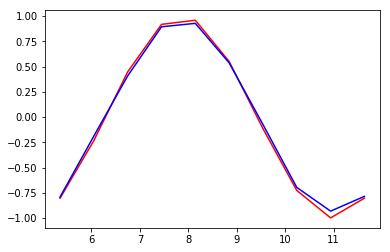

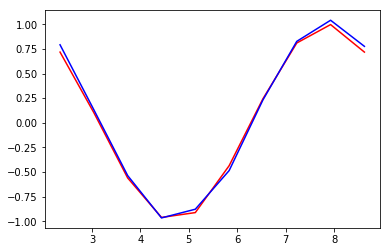

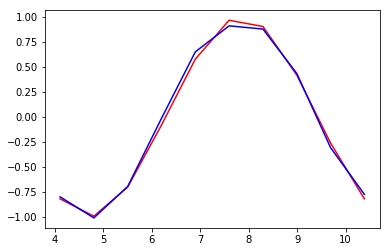

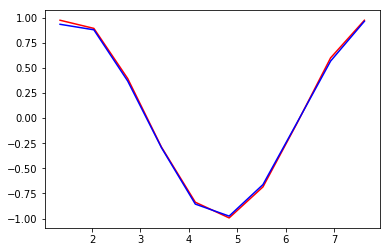

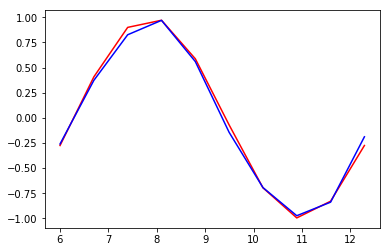

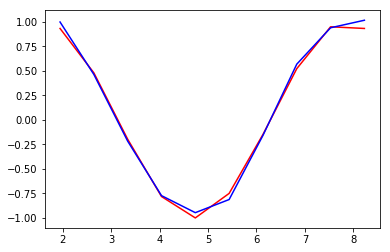

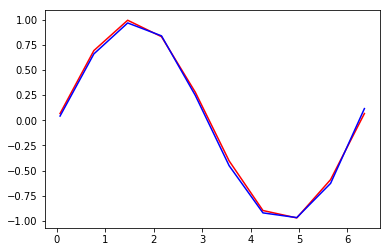

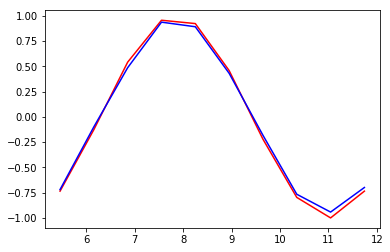

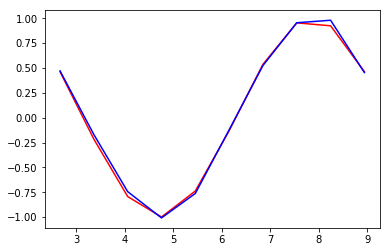

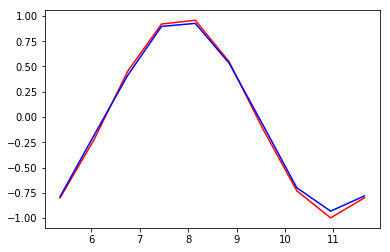

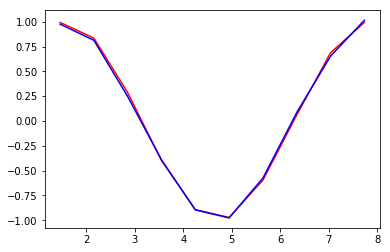

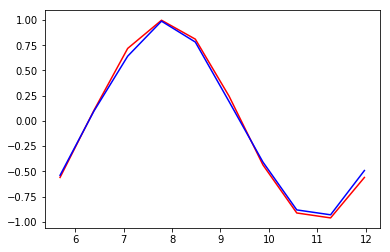

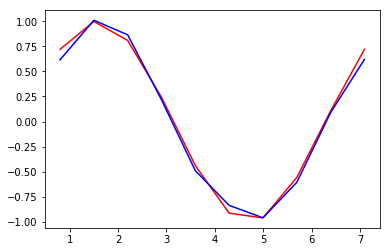

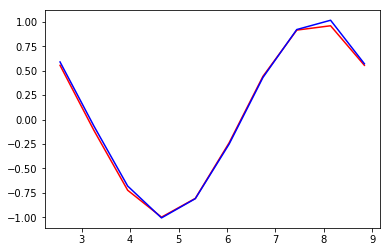

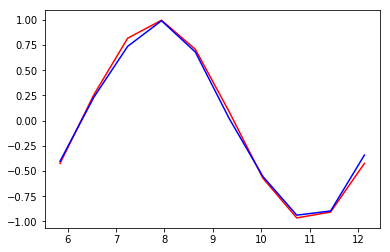

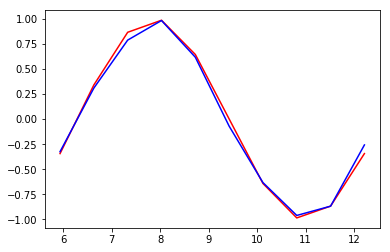

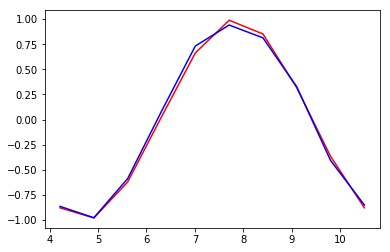

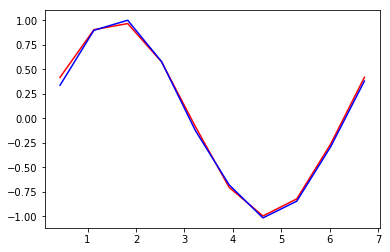

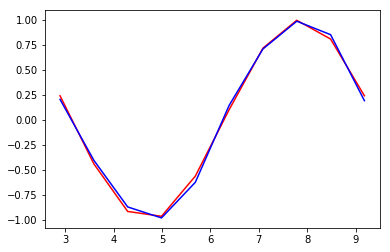

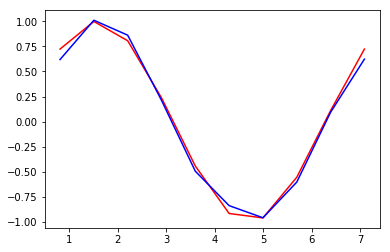

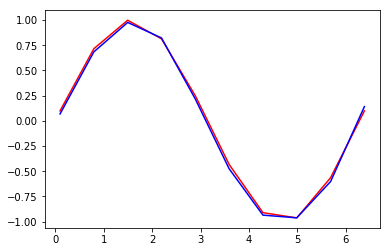

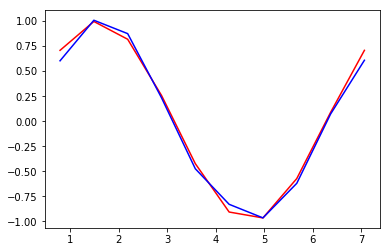

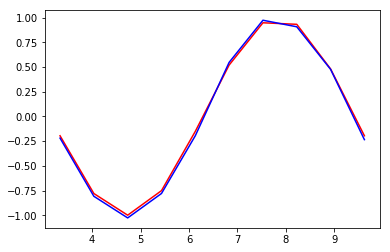

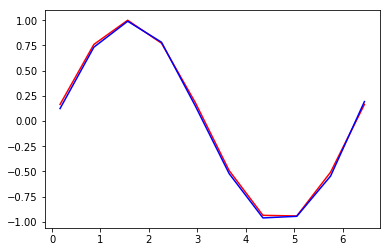

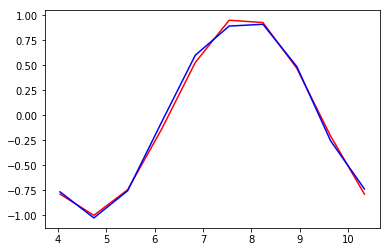

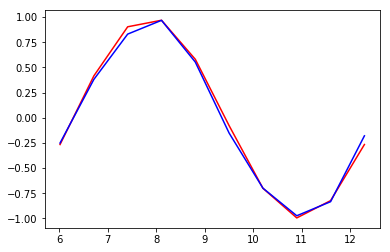

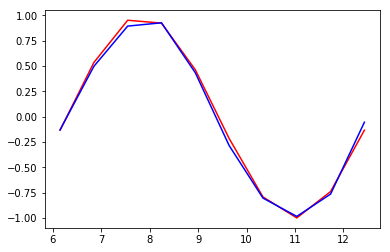

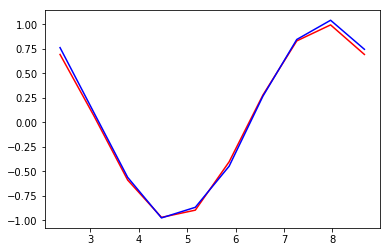

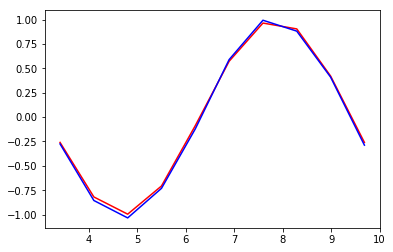

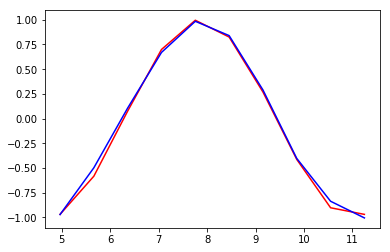

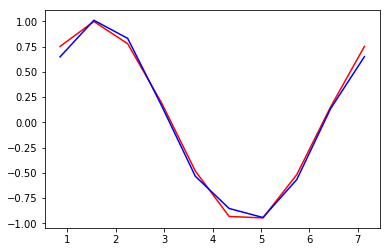

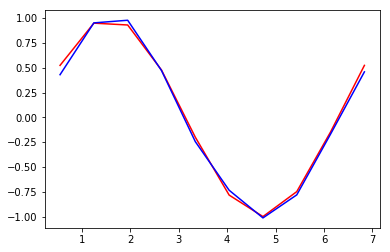

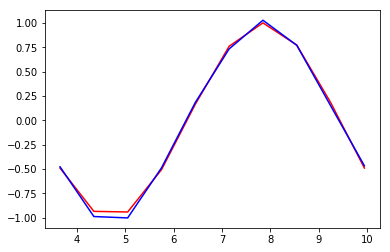

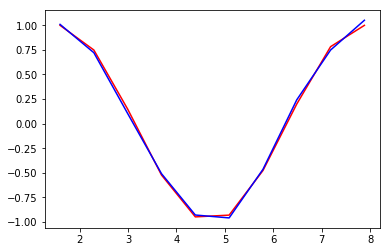

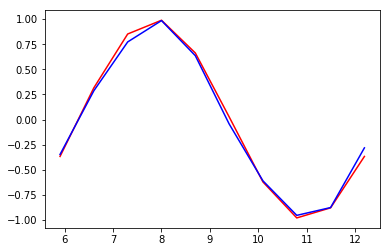

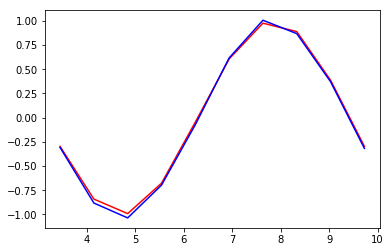

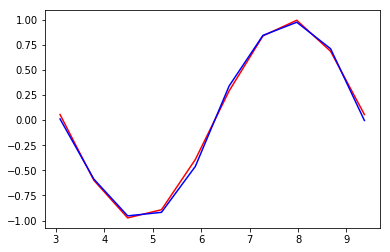

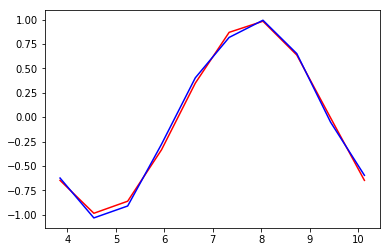

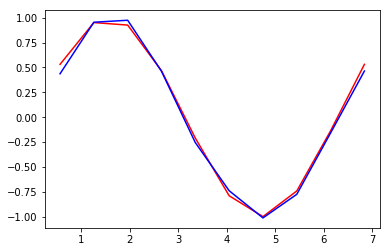

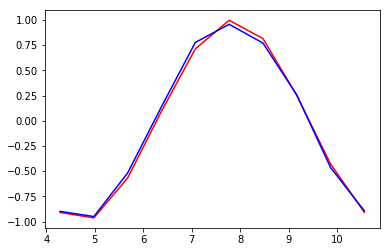

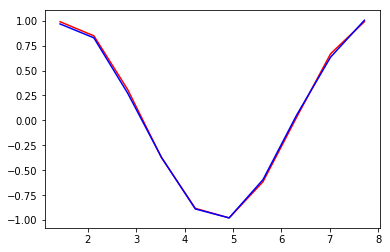

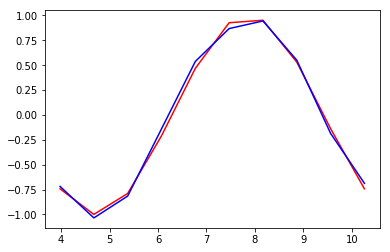

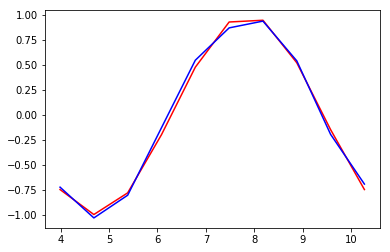

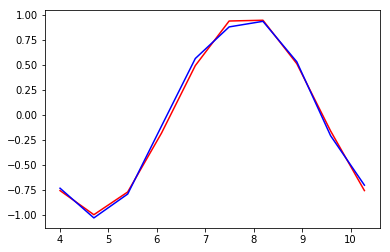

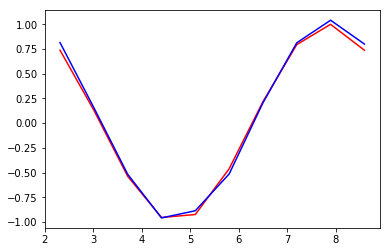

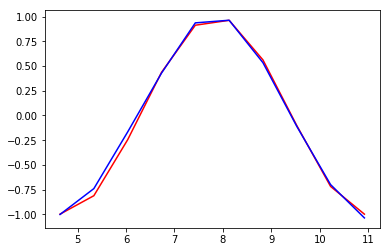

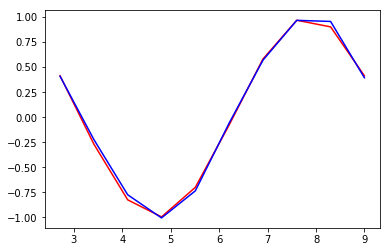

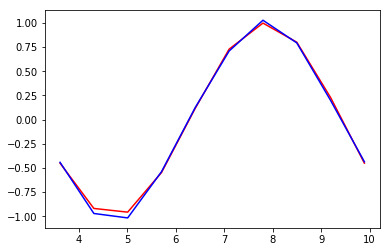

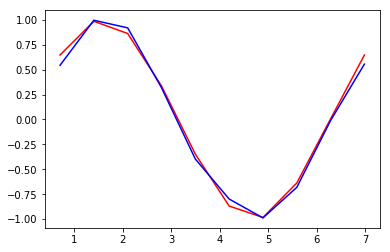

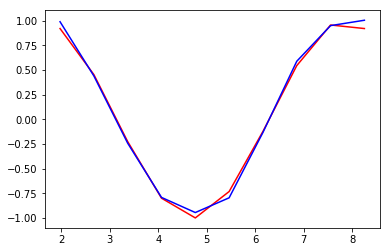

In [152]:
cos_series=[]
sin_series=[]
steps_series=[]

#get 50 samples
for i in range(50):
    # use sin predicts cos
    
    steps = np.linspace(0,2*np.pi, SEQ_SZ,dtype='float32')  # float32 for converting torch FloatTensor
    #steps = np.concatenate((steps,np.linspace(np.pi,2*np.pi, SEQ_SZ/2,dtype='float32')),axis=0)
    start=np.random.uniform(0,2*np.pi)
    steps = np.linspace(start,start+2*np.pi, SEQ_SZ,dtype='float32')  # float32 for converting torch FloatTensor
    sin = np.sin(steps)
    cos = np.cos(steps)
    steps_series.append(steps)
    cos_series.append(np.expand_dims(cos,axis=1))
    sin_series.append( np.expand_dims(sin,axis=1))

cos_series = np.asarray(cos_series)
sin_series = np.asarray(sin_series)

cos_series =  torch.from_numpy(cos_series).type(torch.FloatTensor)
sin_series =  torch.from_numpy(sin_series).type(torch.FloatTensor)


test = list(zip(steps_series,cos_series,sin_series))


test_batches = DataLoader(test,batch_size=BATCH_SZ,shuffle=True,num_workers=4)

plt.ion()

mynet.eval()
acc = 0
n_samples = 0
for index,batch in enumerate( test_batches):
    steps,X_batch,y_batch = batch
    optimizer.zero_grad()
    out= mynet(X_batch)
    y_batch = y_batch.squeeze()
    loss = criterion(out, y_batch)
    #print(out.shape)
    for j in range(X_batch.shape[0]):
        plt.plot(steps[j].numpy().flatten(),y_batch[j].numpy().flatten(),'-r')
        plt.plot(steps[j].numpy().flatten(),out[j].detach().numpy().flatten(),'-b')
        plt.draw()
        plt.pause(0.05)
plt.ioff()
plt.show()

Βλέπουμε ότι σε κάθε περίπτωση σχεδόν ταυτίζεται με το ημίτονο. Τα "σπασίματα" του ημιτόνου οφείλονται στον μικρό αριθμό σημείων που έχουμε επιλέξει.